**Asignatura**: Computación Bio-inspirada, 2024/2025

**Alumnos**:<br>
- Salvador de Haro Orenes (salvadorde.haroo@um.es)
- Jose María Belmonte Martínez (josemaria.belmontem@um.es)

**Máster de Inteligencia Artificial**

**Facultad de Informática**

![](https://www.um.es/image/layout_set_logo?img_id=175281&t=1726728636242)

**Universidad de Murcia**

![](https://www.um.es/o/um-lr-principal-um-home-theme/images/logo-um.png)

# N-REINAS

En este notebook abordaremos la resolución del problema de las N-reinas mediante algoritmos evolutivos. Para ello, usaremos una representación basada en permutaciones para los individuos de la población, es decir, cada individuo (configuración posible del tablero) quedará representado mediante un vector $$individuo_i = (c_{i1}, c_{i2}, \dots, c_{iN})$$ donde cada posición indica en qué columna se encuentra la reina de la fila correspondiente.

En particular, utilizaremos dos algoritmos evolutivos, `AE1` y `AE2`, con las siguientes propiedades:
- `AE1`: Esquema de selección proporcional, muestreo estocástico con reemplazamiento, operador de cruce PMX y mutación swap.
- `AE2`: Esquema de selección por ranking exponencial, muestreo estocástico con reemplazamiento, operador de cruce PMX y mutación swap.

Con el fin de obtener una configuración óptima para las probabilidades de cruce y mutación ($p_c$ y $p_m$) se realizará una búsqueda en un grid de hiperparámetros.

Una vez ajustados los valores de las probabilidades, ejecutaremos cada algoritmo evolutivo 10 veces para obtener diferentes métricas promedio de interés, con el fin de poder comparar a los algoritmos mediante test estadísticos.

## Importación de librerías necesarias

In [35]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import product
import time
import os
import pandas as pd

## Parámetros globables

In [36]:
G = 1000
N = 100
queens = 64
ranks_type = ['roulette', 'exponential']
c = 0.3 #para seleccion de ranking exponencial; estudiar la posibilidad de ajustar este valor en grid.

## Definición de individuo

In [37]:
class Individuo:
    def __init__(self,n):
        self.x = np.zeros(n, dtype='int') ## n, dtype='int'
        self.f = 0.0
    def __lt__(self, ind):
        return self.f < ind.f

## Inicialización de la población

In [38]:
def InitializePopulation(P):
    n = P[0].x.size
    for I in P:
        I.x[:] = np.random.permutation(n)

## Función fitness y método de evaluación de individuos

In [39]:
def f(x):
    """Calcula el número de jaques en diagonal entre reinas dado un array de posiciones."""
    n = len(x)
    conflicts = 0

    # Revisar conflictos en diagonales
    for i in range(n):
        for j in range(i + 1, n):
            if abs(i - j) == abs(x[i] - x[j]):  # Mismo valor absoluto en la diferencia (diagonal)
                conflicts += 1

    return conflicts  # Se devuelve el número de conflictos (positivo)

def evaluate(I, f):           
    """Evalúa el fitness de un individuo y lo guarda en I.f"""
    I.f = f(I.x)  # Se pasa I.x como array a la función fitness

## Copia de individuo

In [40]:
def copia(I1, I2):
    np.copyto(I1.x, I2.x)
    I1.f = I2.f   

## Cálculo de probalidades acumuladas

Como los algoritmos evolutivos involucrados utilizan distinto esquema de selección, necesitaremos un método para cada algoritmo.

### Cálculo de probabilidades acumuladas en `AE1`

Este algoritmo utiliza un esquema de selección proporcional, lo cual favorece la maximización de la función objetivo al asignar mayor probabilidad a los individuos con mayor fitness, que en nuestro caso un fitness alto significa un alto número de amenazas en diagonal. Como queremos lo contrario, es decir, hacer que la función objetivo vaya disminuyendo hasta poder alcanzar un valor óptimo de 0, tendremos que transformar de manera lineal la función fitness, de modo que los individuos con fitness más bajo (los mejores) reciban mayor probabilidad de selección mediante el esquema proporcional. La transformación que proponemos es la siguiente:
$$ f'({\bf x})= C- f({\bf x}) $$

donde $C$ es un valor ligeramente superior al máximo valor de $f({\bf x})$ en la población actual:

$$ C=max_{{\bf x}\in P}\{f({\bf x})\}+\epsilon$$

De este modo, al maximizar $f'({\bf x})$ estaremos maximizando $f({\bf x})$.

In [41]:
def calculate_cumulative_probabilities_AE1(cumulative_probabilities, P, N):
    """
    Calcula las probabilidades acumuladas para la selección proporcional en un algoritmo genético.

    Parámetros:
    - cumulative_probabilities: Lista donde se almacenarán las probabilidades acumuladas.
    - P: Lista de individuos de la población actual.
    - N: Número total de individuos en la población.

    Funcionamiento:
    - Se usa una transformación lineal en la función de aptitud (fitness) para convertir el problema de minimización en uno de maximización.
    - Se calcula la suma total del fitness transformado.
    - Se asignan las probabilidades acumuladas a cada individuo en función de su fitness relativo.
    """

    C = max(P).f + 1e-6  # Se elige C como el mayor valor de fitness en la población más un pequeño epsilon (1e-6).

    # Se calcula la suma del fitness transformado (C - f) ya que el algoritmo es de minimización.
    sum_fitness = sum(C - I.f for I in P)

    # Se calcula la primera probabilidad acumulada
    cumulative_probabilities[0] = (C - P[0].f) / sum_fitness

    # Se calcula la probabilidad acumulada para cada individuo en la población
    for i in range(1, N):
        cumulative_probabilities[i] = cumulative_probabilities[i - 1] + (C - P[i].f) / sum_fitness

### Cálculo de probabilidades acumuladas en `AE2`

En la siguiente función implementamos el cáluclo de las probabilidades acumulativas teniendo en cuenta que el algoritmo `AE2` utiliza selección por ranking exponencial.

In [42]:
def calculate_cumulative_probabilities_AE2(cumulative_probabilities, P, c, rank_type):
    """
    Calcula las probabilidades acumuladas para la selección de ranking exponencial.

    Parámetros:
    - cumulative_probabilities (numpy.ndarray): Vector donde se almacenarán las probabilidades acumuladas.
    - P (list): Lista de individuos de la población actual, ordenados de mejor a peor.
    - c (float): Parámetro de control para la selección exponencial. Debe ser mayor que 1.
    - rank_type (str): Tipo de ranking a usar. Solo soporta "exponential" en esta versión.

    Funcionamiento:
    - Se asignan probabilidades decrecientes de manera exponencial a los individuos.
    - La probabilidad de selección de un individuo depende de su ranking en la población.
    """

    N = len(P)  # Tamaño de la población
    
    if rank_type == 'exponential':
        den = c**N - 1  # Normalización para que la suma total sea 1
        cumulative_probabilities[0] = (c - 1) / den  # Probabilidad del primer individuo

        for i in range(1, N):
            cumulative_probabilities[i] = cumulative_probabilities[i - 1] + ((c - 1) * c**i) / den


## Muestreo estocástico con reemplazamiento (rueda de ruleta)

In [43]:
def selection(P,cumulative_probabilities):
    '''
    Muestreo estocastico con reemplazamiento a partir de probabilidades acumuladas
    '''
    r = np.random.random()
    i = 0
    while (cumulative_probabilities[i]<r):
        i += 1 
    return P[i]

## Cruce PMX

In [44]:
def crossover_pmx(parent1, parent2):
    n = len(parent1.x)
    cx1, cx2 = sorted(np.random.choice(n, 2, replace=False))
    
    child1, child2 = Individuo(n), Individuo(n)
    child1.x[:], child2.x[:] = -1, -1

    child1.x[cx1:cx2+1] = parent1.x[cx1:cx2+1]
    child2.x[cx1:cx2+1] = parent2.x[cx1:cx2+1]

    def completar_hijo(child, parent, cx1, cx2):
        mapping = {parent.x[i]: child.x[i] for i in range(cx1, cx2+1)}
        assigned = set(child.x[cx1:cx2+1])  # Evitar valores duplicados

        for i in range(n):
            if i < cx1 or i > cx2:
                value = parent.x[i]
                while value in mapping and mapping[value] != -1:
                    value = mapping[value]
                if value in assigned:
                    value = next(v for v in range(n) if v not in assigned)
                child.x[i] = value
                assigned.add(value)

        return child

    child1 = completar_hijo(child1, parent2, cx1, cx2)
    child2 = completar_hijo(child2, parent1, cx1, cx2)

    return child1, child2

## Mutación Swap

In [45]:
def mutation_swap(ind, mutation_prob):
    if np.random.random() < mutation_prob:
        i, j = np.random.choice(len(ind.x), 2, replace=False)
        ind.x[i], ind.x[j] = ind.x[j], ind.x[i]
    ind.f = f(ind.x)  # Recalcular fitness siempre
    return ind

## Función para mostrar una configuración de tablero óptima

In [46]:
def plot_n_queens(solution):
    """Dibuja el tablero de ajedrez con las reinas correctamente alineadas."""
    N = len(solution)
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Dibujar el tablero de ajedrez
    for i in range(N):
        for j in range(N):
            color = "white" if (i + j) % 2 == 0 else "gray"
            ax.add_patch(plt.Rectangle((j, N - i - 1), 1, 1, color=color))

    # Dibujar líneas de la cuadrícula
    ax.set_xticks(np.arange(N+1))
    ax.set_yticks(np.arange(N+1))
    ax.grid(which="major", color="black", linestyle='-', linewidth=1)
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    # Dibujar las reinas en el centro exacto de cada celda
    for row, col in enumerate(solution):
        ax.text(col + 0.5, N - row - 0.5, '♛', fontsize=20, ha='center', va='center', color="red")

    ax.set_xlim(0, N)
    ax.set_ylim(0, N)
    plt.title(f"Solución para {N} reinas")
    plt.show()

## Funciones para actualizar progreso del algoritmo evolutivo

In [47]:
def IniciaProgreso(G, best_fitness_inicial):
    """
    Inicializa la barra de progreso para el Algoritmo Evolutivo.
    
    Parámetros:
    - G (int): Número máximo de generaciones.
    - best_fitness_inicial (int): Fitness del mejor individuo en la población inicial.

    Retorna:
    - best_outputs (list): Historial del mejor fitness en cada generación.
    - progression_bar (tqdm object): Barra de progreso.
    """
    best_outputs = [0] * (G + 1)  # Inicializar con valores vacíos
    best_outputs[0] = best_fitness_inicial  # Solo el primer valor es el fitness inicial

    progression_bar = tqdm(total=G, desc="Evolucionando", unit="gen", leave=False)
    return best_outputs, progression_bar

def ActualizaProgreso(P, gen, best_outputs, progression_bar):
    """
    Actualiza la barra de progreso con el mejor fitness actual.

    Parámetros:
    - P (list): Población actual.
    - gen (int): Número de generación actual.
    - best_outputs (list): Historial de fitness.
    - progression_bar (tqdm object): Barra de progreso.
    """
    best_fitness = min(P, key=lambda ind: ind.f).f  # Mejor fitness en la población actual
    best_outputs[gen] = best_fitness  # Guardamos el mejor fitness
    progression_bar.set_postfix(fitness=best_fitness)  # Actualizar la barra con el mejor fitness
    progression_bar.update(1)  # Avanzar la barra en una unidad

## Algoritmos evolutivos: `AE1` y `AE2`

Ambos algoritmos implementan elitismo para asegurar que el mejor individuo de la población actual sobrevive en la población de la siguiente generación.

### `AE1`

In [48]:
def AE1(G, N, prob, rank_type, random_state, show_progress=True):
    """
    Algoritmo Evolutivo con opción para desactivar la barra de progreso y con elitismo.

    Parámetros:
    - G (int): Número máximo de generaciones.
    - N (int): Tamaño de la población.
    - prob (tuple): (probabilidad de cruce, probabilidad de mutación).
    - rank_type (str): Tipo de ranking usado en la selección.
    - random_state (int): Semilla aleatoria.
    - show_progress (bool): Si True, muestra la barra de progreso; si False, no la muestra.

    Retorna:
    - best_outputs (list): Historial del mejor fitness por generación.
    - best_fitness (float): Mejor fitness encontrado.
    - best_solution (list): Representación de la mejor solución.
    - num_generations (int): Número de generaciones necesarias para encontrar la mejor solución.
    """

    np.random.seed(random_state)
    prob_cross, prob_mutation = prob

    assert G >= 1, "El número de generaciones debe ser mayor o igual que 1."
    assert N >= 2 and not N % 2, "El tamaño de la población debe ser par y mayor que 1."

    cumulative_probabilities = np.zeros(N)

    # Crear y inicializar población
    P = [Individuo(queens) for _ in range(N)]
    InitializePopulation(P)

    # Evaluar población inicial
    for I in P:
        evaluate(I, f)

    # Guardar mejor individuo inicial (para elitismo)
    best_individuo = min(P, key=lambda ind: ind.f)

    # Inicializar barra de progreso solo si show_progress es True
    best_outputs, progression_bar = (IniciaProgreso(G, best_fitness_inicial=best_individuo.f) 
                                     if show_progress else ([best_individuo.f] * (G + 1), None))

    for gen in range(1, G + 1):
        # Calcular probabilidades acumuladas con fitness ajustado
        calculate_cumulative_probabilities_AE1(cumulative_probabilities, P, N)

        Q = []
        i = 0
        while i < N:
            parent1 = selection(P, cumulative_probabilities)
            parent2 = selection(P, cumulative_probabilities)

            if np.random.random() < prob_cross:
                child1, child2 = crossover_pmx(parent1, parent2)
            else:
                child1, child2 = Individuo(len(parent1.x)), Individuo(len(parent2.x))
                copia(child1, parent1)
                copia(child2, parent2)

            # Aplicamos mutación con menor probabilidad
            child1 = mutation_swap(child1, mutation_prob=prob_mutation)
            child2 = mutation_swap(child2, mutation_prob=prob_mutation)

            Q.append(child1)
            Q.append(child2)
            i += 2    

        # Evaluar nueva población antes de ordenarla
        for I in Q:
            evaluate(I, f)

        # Sustitución generacional con elitismo
        Q = sorted(Q, key=lambda ind: ind.f)  # Ordenar nueva generación (mejores primero)
        
        # Asegurar que el mejor individuo anterior pase a la nueva generación ----> ELITISMO
        if best_individuo.f < Q[-1].f:  # Si el mejor anterior es mejor que el peor de Q
            Q[-1] = best_individuo  # Sustituimos al peor de Q con el mejor de la generación anterior
        
        # Actualizar población con la nueva generación
        P = Q

        # Guardar mejor individuo actualizado
        best_individuo = min(P, key=lambda ind: ind.f)

        # Actualizar la barra de progreso solo si está activa
        if show_progress:
            ActualizaProgreso(P, gen, best_outputs, progression_bar)

        # Criterio de terminación (si encontramos una solución válida)
        if best_individuo.f == 0:
            if show_progress:
                progression_bar.set_description(f"✅ Solución encontrada en {gen} generaciones")
                progression_bar.close()
            return best_outputs, best_individuo.f, best_individuo.x, gen

    if show_progress:
        progression_bar.close()
    return best_outputs, best_individuo.f, best_individuo.x, G  # Retornar total de generaciones si no encontró solución

### `AE2` 

In [49]:
def AE2(G, N, prob, rank_type, random_state, show_progress=True):
    """
    Algoritmo Evolutivo con opción para desactivar la barra de progreso y con elitismo.

    Parámetros:
    - G (int): Número máximo de generaciones.
    - N (int): Tamaño de la población.
    - prob (tuple): (probabilidad de cruce, probabilidad de mutación).
    - rank_type (str): Tipo de ranking usado en la selección.
    - random_state (int): Semilla aleatoria.
    - show_progress (bool): Si True, muestra la barra de progreso; si False, no la muestra.

    Retorna:
    - best_outputs (list): Historial del mejor fitness por generación.
    - best_fitness (float): Mejor fitness encontrado.
    - best_solution (list): Representación de la mejor solución.
    - num_generations (int): Número de generaciones necesarias para encontrar la mejor solución.
    """

    np.random.seed(random_state)
    prob_cross, prob_mutation = prob

    assert G >= 1, "El número de generaciones debe ser mayor o igual que 1."
    assert N >= 2 and not N % 2, "El tamaño de la población debe ser par y mayor que 1."

    cumulative_probabilities = np.zeros(N)

    # Crear y inicializar población
    P = [Individuo(queens) for _ in range(N)]
    InitializePopulation(P)

    # Evaluar población inicial
    for I in P:
        evaluate(I, f)

    # Ordenar la población para que el mejor individuo esté en la primera posición
    P = sorted(P, key=lambda ind: ind.f)
    best_individuo = P[0]  # Guardar mejor individuo inicial

    # Inicializar barra de progreso si está activada
    best_outputs, progression_bar = (
        IniciaProgreso(G, best_fitness_inicial=best_individuo.f) if show_progress
        else ([best_individuo.f] * (G + 1), None)
    )

    for gen in range(1, G + 1):
        calculate_cumulative_probabilities_AE2(cumulative_probabilities, P, c, rank_type)

        Q = [Individuo(len(P[0].x)) for _ in range(N)]  # Nueva población

        # **Elitismo: Mantener al mejor individuo en la nueva población**
        Q[0] = best_individuo  

        i = 1  # Comenzamos en 1 porque Q[0] ya está ocupado por el mejor individuo
        while i < N:
            parent1 = selection(P, cumulative_probabilities)
            parent2 = selection(P, cumulative_probabilities)

            if np.random.random() < prob_cross:
                child1, child2 = crossover_pmx(parent1, parent2)
            else:
                child1, child2 = Individuo(len(parent1.x)), Individuo(len(parent2.x))
                copia(child1, parent1)
                copia(child2, parent2)

            # Aplicamos mutación con menor probabilidad
            child1 = mutation_swap(child1, mutation_prob=prob_mutation)
            child2 = mutation_swap(child2, mutation_prob=prob_mutation)

            Q[i], Q[i + 1] = child1, child2
            i += 2  

        # Evaluar nueva población antes de ordenarla
        for I in Q[1:]:  # Evaluamos desde el índice 1 porque Q[0] ya tiene el mejor individuo previo
            evaluate(I, f)

        # Ordenar nueva población
        Q = sorted(Q, key=lambda ind: ind.f)

        # Reemplazar población anterior por la nueva
        P = Q  

        # Actualizar mejor individuo si encontramos uno mejor
        if P[0].f < best_individuo.f:
            best_individuo = P[0]

        # Actualizar barra de progreso si está activa
        if show_progress:
            ActualizaProgreso(P, gen, best_outputs, progression_bar)

        # Criterio de terminación: Si encontramos una solución óptima
        if best_individuo.f == 0:
            if show_progress:
                progression_bar.set_description(f"✅ Solución encontrada en {gen} generaciones")
                progression_bar.close()
            return best_outputs, best_individuo.f, best_individuo.x, gen

    if show_progress:
        progression_bar.close()

    return best_outputs, best_individuo.f, best_individuo.x, G  # Retornar total de generaciones si no encontró solución

## Ajuste de hiperparámetros mediante GridSearch

Para algoritmo, se ajustarán la probabilidad de cruce ($p_c$) y la probabilidad de mutación ($p_m$) mediante una búsqueda en un grid de 10x10 (100 combinaciones posibles, usando 10 valores para $p_c$ y $p_m$). A su vez, para combinación $(p_c, p_m)$, cada algoritmo se ejecutará 3 veces, usando en cada ejecución una semilla de números aleatorios distinta. A partir de esas 3 ejecuciones se calculará el valor fitness promedio obtenido.

In [50]:
# Definir la grid de hiperparámetros
cross_probs = np.linspace(0.1, 1.0, 10)  # 10 valores en (0.0, 1.0]
mut_probs = np.linspace(0.05, 0.3, 10)  # 10 valores en (0.0, 0.3]

# Crear combinaciones de hiperparámetros
param_grid = list(product(cross_probs, mut_probs))

# Definir número de repeticiones
num_repetitions = 3

### Función para ejecutar GridSearch

In [51]:
def evaluate_hyperparameters(param_grid, num_repetitions, rank_type, ae, G=1000, N=100):
    """
    Ejecuta Grid Search para determinar la mejor combinación de p_c y p_m.

    Parámetros:
    - param_grid: Lista con combinaciones de (p_c, p_m).
    - num_repetitions: Número de veces que se ejecuta cada combinación con semillas distintas.
    - rank_type: Tipo de selección usada (proporcional o ranking exponencial).
    - ae: Número entero que indica si el algoritmo evolutivo que deseamos ajustar: 1 o 2.
    - G: Número de generaciones.
    - N: Tamaño de la población.

    Retorna:
    - best_params: Mejor combinación de (p_c, p_m) encontrada.
    - best_metrics: Métricas asociadas a los mejores hiperparámetros.
    """

    assert ae == 1 or ae == 2 #ae debe ser 1 o 2

    results = []

    with tqdm(total=len(param_grid), desc="Evaluando hiperparámetros", unit="iter") as pbar:
        for p_c, p_m in param_grid:
            fitness_values = []
            generations_needed = []
            success_count = 0  # Contador de ejecuciones exitosas

            for rep in range(num_repetitions):
                random_state = rep  # Usamos diferentes semillas
                prob = (p_c, p_m)

                # Ejecutar el algoritmo evolutivo
                if ae == 1:
                    _, best_fitness, _, num_generations = AE1(G, N, prob, rank_type, random_state, show_progress=False)
                else:
                    _, best_fitness, _, num_generations = AE2(G, N, prob, rank_type, random_state, show_progress=False)
                # Guardar métricas
                fitness_values.append(best_fitness)
                generations_needed.append(num_generations)

                # Contar si encontramos una solución óptima (fitness = 0)
                if best_fitness == 0:
                    success_count += 1

            # Calcular estadísticas de la combinación
            avg_fitness = np.mean(fitness_values)
            std_fitness = np.std(fitness_values)
            avg_generations = np.mean(generations_needed)
            std_generations = np.std(generations_needed)
            success_rate = success_count / num_repetitions  # Proporción de éxito

            results.append((p_c, p_m, avg_fitness, std_fitness, avg_generations, std_generations, success_rate)) #results sera una lista de 10x10 = 100 elementos con los resultados para cada par (pc, pm)

            pbar.update(1)  # Avanzar la barra de progreso

    # Convertir resultados en un array estructurado
    results = np.array(results, dtype=[
        ('p_c', float), ('p_m', float),
        ('fitness', float), ('std_fitness', float),
        ('generations', float), ('std_generations', float),
        ('success_rate', float)
    ])

    # Seleccionar la mejor combinación:
    # 🔹 Primero, buscamos la de menor fitness promedio
    best_indices = np.where(results['fitness'] == np.min(results['fitness']))[0]

    if len(best_indices) == 1:
        best_index = best_indices[0]  # Si hay un único mínimo, seleccionamos ese
    else:
        # 🔹 En caso de empate en fitness, elegimos la que requiera menos generaciones promedio
        best_index = best_indices[np.argmin(results['generations'][best_indices])]

    best_params = (results[best_index]['p_c'], results[best_index]['p_m'])

    best_metrics = {
        "fitness_promedio": results[best_index]['fitness'],
        "fitness_std": results[best_index]['std_fitness'],
        "generaciones_promedio": results[best_index]['generations'],
        "generaciones_std": results[best_index]['std_generations'],
        "tasa_exito": results[best_index]['success_rate']
    }

    return best_params, best_metrics

### GridSearch para `AE1`

In [ ]:
best_params_ae1, best_metrics_gridsearch_ae1 = evaluate_hyperparameters(param_grid, num_repetitions=3, rank_type=ranks_type[0], ae = 1, G = 500, N = 14)

print(f"🔹 Mejor combinación encontrada: p_c={best_params_ae1[0]}, p_m={best_params_ae1[1]}")
print()
print('Donde los resultados estadísticos más relevantes fueron:')
print()
print(f"🔹 Fitness promedio: {best_metrics_gridsearch_ae1['fitness_promedio']}")
print(f"🔹 Desviación estándar del fitness: {best_metrics_gridsearch_ae1['fitness_std']}")
print(f"🔹 Generaciones promedio para convergencia: {best_metrics_gridsearch_ae1['generaciones_promedio']}")
print(f"🔹 Desviación estándar de generaciones: {best_metrics_gridsearch_ae1['generaciones_std']}")
print(f"🔹 Tasa de éxito: {best_metrics_gridsearch_ae1['tasa_exito']}")

Evaluando hiperparámetros:  25%|██▌       | 25/100 [08:52<26:17, 21.03s/iter]

### GridSearch para `AE2` 

In [ ]:
best_params_ae2, best_metrics_gridsearch_ae2 = evaluate_hyperparameters(param_grid, num_repetitions=3, rank_type=ranks_type[1], G = 500, N = 14)

print(f"🔹 Mejor combinación encontrada: p_c={best_params_ae2[0]}, p_m={best_params_ae2[1]}")
print()
print('Donde los resultados estadísticos más relevantes fueron:')
print()
print(f"🔹 Fitness promedio: {best_metrics_gridsearch_ae2['fitness_promedio']}")
print(f"🔹 Desviación estándar del fitness: {best_metrics_gridsearch_ae2['fitness_std']}")
print(f"🔹 Generaciones promedio para convergencia: {best_metrics_gridsearch_ae2['generaciones_promedio']}")
print(f"🔹 Desviación estándar de generaciones: {best_metrics_gridsearch_ae2['generaciones_std']}")
print(f"🔹 Tasa de éxito: {best_metrics_gridsearch_ae2['tasa_exito']}")

## Ejecuciones `AE1` y `AE2` 

### Función genérica para ejecutar un algoritmo evolutivo

In [ ]:
def EjecutaEA(nRun, G, N, ae, best_params, rank_type):
    """
    Ejecuta el Algoritmo Evolutivo nRun veces y guarda la evolución del fitness.

    Parámetros:
    - nRun (int): Número de ejecuciones a realizar.
    - G (int): Número de generaciones.
    - N (int): Tamaño de la población.
    - ae (int): Un valor 1 para ejecutar AE1, un valor 2 para ejecutar AE2
    - best_params (tuple): (p_c, p_m) de la mejor configuración encontrada.
    - rank_type (str): Tipo de ranking usado en la selección.

    Retorna:
    - best_fitness_by_generations (array): Evolución del fitness en cada ejecución.
    - best_fitness_by_execution (array): Mejor fitness final por ejecución.
    - best_solution_by_execution (array): Mejor solución por ejecución.
    - num_generations_by_execution (array): Número de generaciones necesarias por ejecución.
    """
    
    # Inicialización de arrays
    best_fitness_by_generations = np.zeros((nRun, G + 1))  # Guardar fitness en cada generación
    best_fitness_by_execution = np.zeros(nRun)
    best_solution_by_execution = [None] * nRun
    num_generations_by_execution = np.zeros(nRun)
    
    for i in range(nRun):
        start_time = time.time()
        random_state = i  # Usamos i como semilla para reproducibilidad

        # Ejecutar EA y almacenar resultados
        if ae == 1:
            best_outputs, best_fitness, best_solution, num_generations = AE1(G, N, best_params, rank_type, random_state)
        else:
            best_outputs, best_fitness, best_solution, num_generations = AE2(G, N, best_params, rank_type, random_state)

        best_fitness_by_generations[i] = best_outputs  # Guardar evolución del fitness
        best_fitness_by_execution[i] = best_fitness
        best_solution_by_execution[i] = best_solution
        num_generations_by_execution[i] = num_generations

        elapsed_time = time.time() - start_time
        print(f"🔹 Run {i+1}/{nRun} completado en {elapsed_time:.2f} segundos - Mejor fitness: {best_fitness}")

    return best_fitness_by_generations, best_fitness_by_execution, best_solution_by_execution, num_generations_by_execution

### Función para graficar la evolución del mejor fitness

In [ ]:
def graficar_evolucion_fitness_grid(best_fitness_by_generations, titulo):
    """
    Grafica la evolución del fitness en un grid de 5x2, mostrando una gráfica por cada ejecución.

    Parámetros:
    - best_fitness_by_generations (numpy.ndarray): Matriz de tamaño (nRun, G+1) con la evolución del fitness.
    - titulo (str): Título general de la figura.
    """
    nRun = best_fitness_by_generations.shape[0]  # Número de ejecuciones
    fig, axes = plt.subplots(5, 2, figsize=(12, 15))  # Crear grid de 5x2
    fig.suptitle(titulo, fontsize=16)

    for i, ax in enumerate(axes.flat):  # Iterar sobre los 10 subgráficos
        if i < nRun:  # Solo graficamos si hay datos disponibles
            ax.plot(best_fitness_by_generations[i], label=f"Ejecución {i+1}", color="blue")
            ax.set_xlabel("Generaciones")
            ax.set_ylabel("Mejor Fitness")
            ax.set_title(f"Ejecución {i+1}")
            ax.grid()
        else:
            ax.axis("off")  # Ocultar gráficos extra en caso de haber menos de 10 ejecuciones

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar el layout sin solapar el título
    plt.show()


### `AE1`

In [ ]:
best_fitness_by_generations_AE1, best_fitness_by_execution_AE1, best_solution_by_execution_AE1, num_generations_by_execution_AE1 = EjecutaEA(nRun=10, G = G, N = N, ae = 1, best_params=best_params_ae2, rank_type=ranks_type[0])

🔹 Run 1/10 completado en 38.74 segundos - Mejor fitness: 0


🔹 Run 2/10 completado en 82.25 segundos - Mejor fitness: 0


🔹 Run 3/10 completado en 91.08 segundos - Mejor fitness: 0


🔹 Run 4/10 completado en 119.01 segundos - Mejor fitness: 2


🔹 Run 5/10 completado en 118.74 segundos - Mejor fitness: 1


🔹 Run 6/10 completado en 122.15 segundos - Mejor fitness: 1


🔹 Run 7/10 completado en 87.88 segundos - Mejor fitness: 0


🔹 Run 8/10 completado en 116.27 segundos - Mejor fitness: 2


🔹 Run 9/10 completado en 68.16 segundos - Mejor fitness: 0


🔹 Run 10/10 completado en 104.17 segundos - Mejor fitness: 0


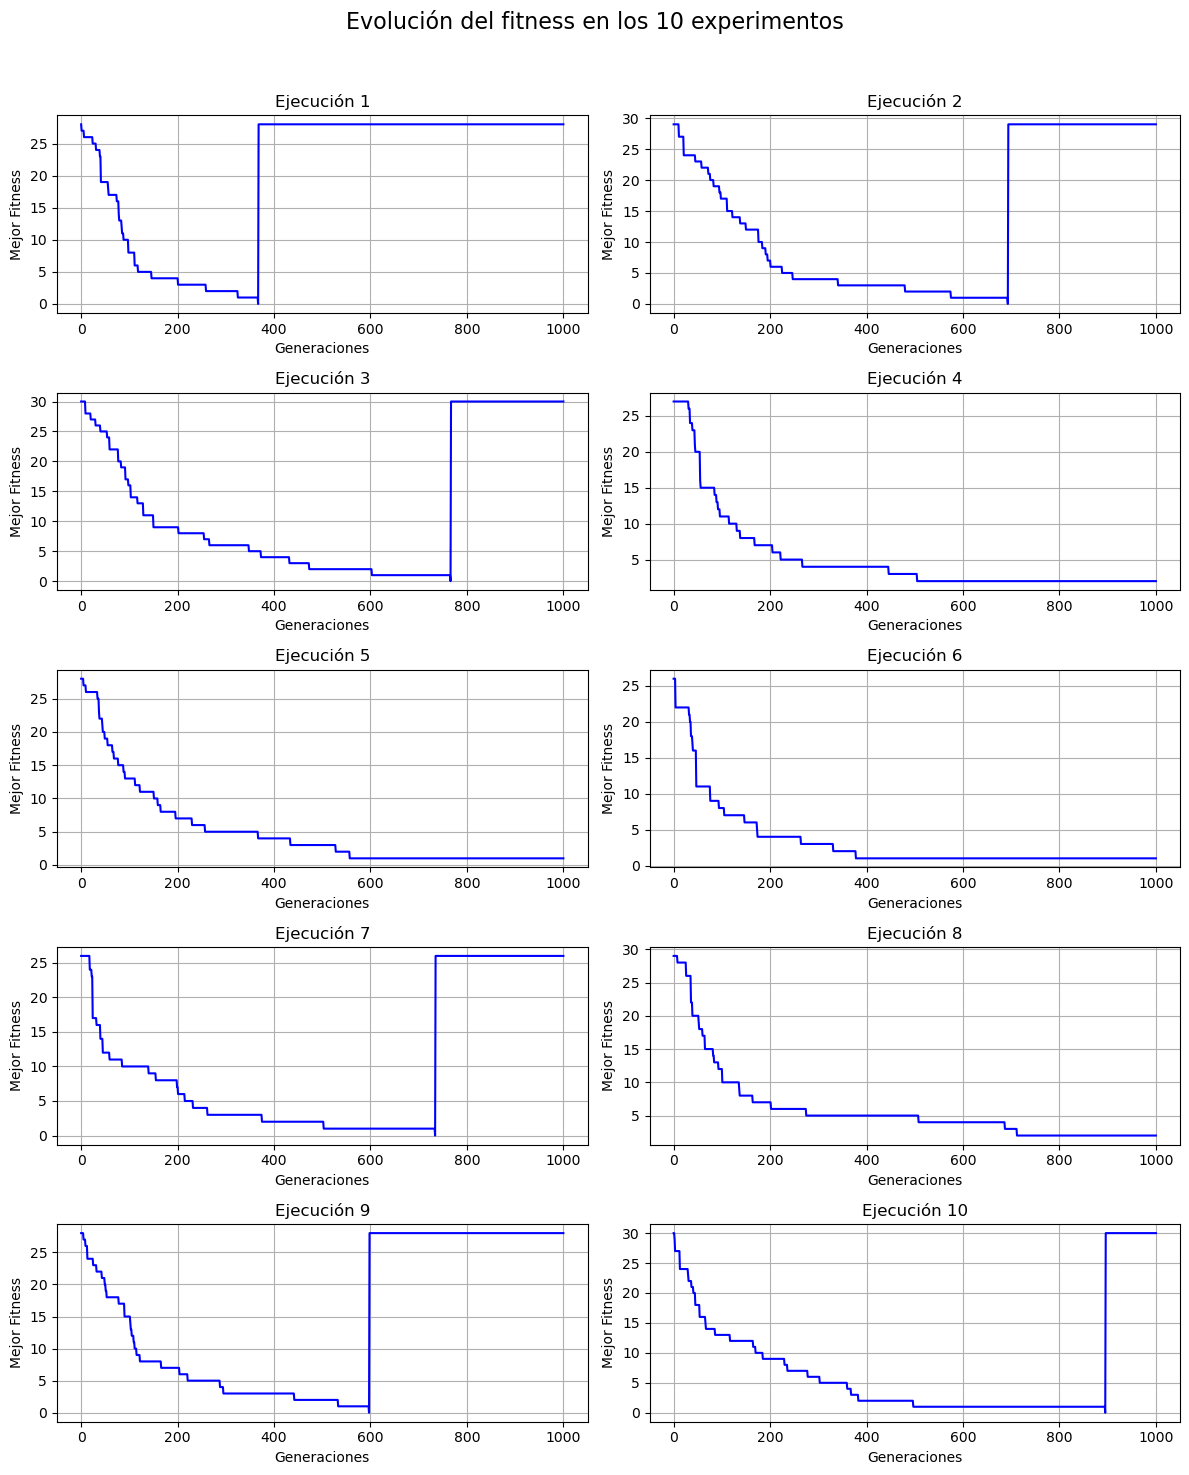

In [ ]:
graficar_evolucion_fitness_grid(best_fitness_by_generations_AE1, titulo="Evolución del fitness en los 10 experimentos")

In [ ]:
# Calcular métricas clave para AE1
fitness_promedio_AE1 = np.mean(best_fitness_by_execution_AE1)  # Fitness promedio
generaciones_promedio_AE1 = np.mean(num_generations_by_execution_AE1)  # Generaciones promedio
tasa_exito_AE1 = np.sum(np.array(best_fitness_by_execution_AE1) == 0) / len(best_fitness_by_execution_AE1)  # Tasa de éxito

# Mostrar resultados en consola
print(f"Fitness Promedio AE1: {fitness_promedio_AE1:.2f}")
print(f"Número de Generaciones Promedio AE1: {generaciones_promedio_AE1:.2f}")
print(f"Tasa de Éxito AE1: {tasa_exito_AE1:.2%}")  # Convertimos a porcentaje

Fitness Promedio AE1: 0.60
Número de Generaciones Promedio AE1: 805.20
Tasa de Éxito AE1: 60.00%


### `AE2`

In [ ]:
best_fitness_by_generations_AE2, best_fitness_by_execution_AE2, best_solution_by_execution_AE2, num_generations_by_execution_AE2 = EjecutaEA(nRun=10, G = G, N = N, ae = 2, best_params=best_params_ae2, rank_type=ranks_type[1])

In [ ]:
graficar_evolucion_fitness_grid(best_fitness_by_generations_AE2, titulo="Evolución del fitness en los 10 experimentos")

In [ ]:
# Calcular métricas clave para AE2
fitness_promedio_AE2 = np.mean(best_fitness_by_execution_AE2)  # Fitness promedio
generaciones_promedio_AE2 = np.mean(num_generations_by_execution_AE2)  # Generaciones promedio
tasa_exito_AE2 = np.sum(np.array(best_fitness_by_execution_AE2) == 0) / len(best_fitness_by_execution_AE2)  # Tasa de éxito

# Mostrar resultados en consola
print(f"Fitness Promedio AE2: {fitness_promedio_AE2:.2f}")
print(f"Número de Generaciones Promedio AE2: {generaciones_promedio_AE2:.2f}")
print(f"Tasa de Éxito AE2: {tasa_exito_AE2:.2%}")  # Convertimos a porcentaje

## Creación de fichero CSV para los tests estadísticos

In [ ]:
# Nombre del archivo CSV donde se guardarán los resultados
csv_filename = "num_gen.csv"

# Datos de AE1
num_generations_ae1 = num_generations_by_execution_AE1  # Lista con iteraciones de AE1

# Crear un DataFrame con la columna AE1
df_ae1 = pd.DataFrame({"AE1": num_generations_ae1})

# Guardar o crear el archivo
df_ae1.to_csv(csv_filename, index=True)  # Se guarda con índice para representar la ejecución

print(f"✅ Resultados de AE1 guardados en {csv_filename}. Ahora ejecuta el notebook de AE2.")

✅ Resultados de AE1 guardados en num_gen.csv. Ahora ejecuta el notebook de AE2.


In [ ]:
# Datos de AE2
num_generations_ae2 = num_generations_by_execution_AE2  # Lista con iteraciones de AE2

# Cargar el archivo si existe
if os.path.exists(csv_filename):
    df_existing = pd.read_csv(csv_filename, index_col=0)  # Cargar sin modificar índice
    df_existing["AE2"] = num_generations_ae2  # Agregar columna AE2
    df_existing.to_csv(csv_filename)  # Guardar de nuevo
    print(f"✅ Resultados de AE2 añadidos en {csv_filename}.")
else:
    print(f"⚠️ ERROR: No se encontró {csv_filename}. Ejecuta primero el notebook de AE1.")